In [96]:
#!pip install py-vkontakte
#библиотека:      
import vk
from tqdm import tqdm

import requests
import time
import pickle
import json
import pandas as pd
import datetime
import re
import numpy as np

from collections import Counter

import re
import numpy as np
from datetime import date
from collections import Counter

In [3]:
#functions to save data partially by 500k items
def to_pickle(data):
    with open(f'data/alive_users_info/alive_{len(data)-500000}-{len(data)}.pickle', 'wb') as f:
        return pickle.dump(data, f)

#functions to save data in the end of parsing
def to_pickle_final(data):
    with open(f'data/alive_users_info/dict_0-2kk_users.pickle', 'wb') as f:
        return pickle.dump(data, f)

def from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)    

# Parse 'Overhear' group users  
with using python client for api vk.com: https://github.com/sgaynetdinov/py-vkontakte

In [17]:
access_token = 'ce37271ace37271ace37271a52ce421894cce37ce37271aae352a1f84a2e8f41385b6cd'
group_name = 'overhear'

In [123]:
##use python client for api vk.com
api = vk.Api(access_token)
group = api.get_group(group_name)

#get group members
get_mem = group.get_members()
users = [] 
for member in tqdm(get_mem):
    users.append(member)

4009815it [47:29, 1407.21it/s]


In [124]:
##in case of previous loop breakes:
##comment users = []
#for member in tqdm(get_mem):
    #users.append(member)

In [125]:
##SAVE
#with open('data/graph/users_4millions.pickle', 'wb') as f:
     #pickle.dump(users, f)

# Parse users' info

### Filter active='alive' users and save them partially

In [4]:
#with open('data/graph/users_4millions.pickle', 'rb') as f:
     #users = pickle.load(f)

In [313]:
#check if user is active by his last_seen time
alive_users = []
for user in tqdm(users):
    if user.last_seen: #return datetime.datetime
        if user.last_seen.year in (2019, 2020, 2021):
            alive_users.append(user)    
print(len(alive_users))
print(len(users))

100%|██████████| 4009815/4009815 [00:40<00:00, 99206.51it/s] 

2507444
4009815


In [332]:
##SAVE
#with open('data/vk_object_2kk_users.pickle', 'wb') as f:
     #pickle.dump(alive_users, f)

### Get 'alive' users unfo

In [100]:
##if we've restarted kernel and cleaned output, run the cell
#alive_users = from_pickle('data/alive_users_info/vk_object_0-2kk_users.pickle')

In [225]:
user_dict = []
unies = []
for user in tqdm(alive_users):
    
    #grab user's educational info
    uni_info=[]
    try:
        if user.get_universities():
            uni_name = user.get_universities()[0].name
            uni_chair = user.get_universities()[0].chair_name
            uni_status = user.get_universities()[0].education_status
        
            uni_info.extend((uni_name, uni_chair, uni_status))
        else:
            uni_info = ''
    
    except IndexError as error:
        uni_info = ''
        
    unies.append(uni_info)
    
    #grab user's id, geo and gender info
    user_id = user.id
    
    if user.bdate:
        if len(user.bdate.split('.')) == 3:
            bdate = user.bdate.split('.')[-1]
    else:
        bdate = ''

    if user.sex:
        sex = user.sex
    else:
        sex = ''
        
    if user.get_country():
        country = user.get_country().title
    else:
        country = ''
    
    if user.get_city():
        city = user.get_city().title
    else:
        city = ''

    user_dict_ = {
    'user_id':user_id,
    'bdate':bdate,
    'country':country,
    'city':city,
    'sex':sex,
    'uni':uni_info}
    
    user_dict.append(user_dict_)

    if len(user_dict)%500000 == 0:
        to_pickle(user_dict)

100%|██████████| 53931/53931 [3:04:21<00:00,  4.88it/s]   


## Merge all parts of users info into one

In [236]:
a = from_pickle('data/alive_users_info_autosave/0-1500k/alive_0-500k.pickle')
b = from_pickle('data/alive_users_info_autosave/0-1500k/alive_500k-1kk.pickle')
c = from_pickle('data/alive_users_info_autosave/0-1500k/alive_1kk-1500k.pickle')
print(len(a), len(b), len(c))

500000 500000 500000


In [241]:
#to concatenate two lists with dicts and sort them by user id
new_file_ = [*a, *b, *c, *user_dict]
new_file = sorted(new_file_, key=lambda k: k['user_id']) 

print(len(new_file))
print(len(new_file) == len(alive_users))

2507444
True


In [246]:
to_pickle_final(new_file)

https://leftjoin.ru/all/vk-api-parse-audience/

## Make DataFrame and csv from the dictionary

In [4]:
#df_2kk_users = from_pickle('data/alive_users_info/dict_0-2kk_users.pickle')

In [5]:
df_2kk_users = (pd.DataFrame(df_2kk_users)
                .replace(r'^\s*$', np.nan, regex=True)) 

In [6]:
print(df_2kk_users.shape)
print(df_2kk_users.isna().sum())

(2507444, 6)
user_id          0
bdate       866351
country     348833
city        624514
sex            494
uni        2293304
dtype: int64


In [7]:
#chek if there are any duplicates
boolean = df_2kk_users.duplicated(subset=['user_id']).any() # True
print(boolean, end='\n\n')

df_2kk_users.drop_duplicates(subset=['user_id'], inplace=True)
print(df_2kk_users.shape)

True

(2507443, 6)


In [48]:
df_2kk_users['bdate'] = (pd.to_datetime(df_2kk_users['bdate'], 
                         errors='coerce')\
                         .dt.year.astype('Int64'))

current_year = date.today().year
df_2kk_users['age'] = current_year - df_2kk_users['bdate']

In [49]:
df_2kk_users.head()

,user_id,bdate,country,city,sex,uni,age
0,177,1988,Россия,Москва,female,NaN,33
1,243,1987,Россия,Санкт-Петербург,female,NaN,34
2,345,1987,США,Boston,female,NaN,34
3,397,1986,Россия,Санкт-Петербург,female,NaN,35
4,431,1985,Россия,Санкт-Петербург,female,NaN,36


In [50]:
#df_2kk_users.to_pickle('data/alive_users_info/df_2kk_users.pickle')

## Download table

In [4]:
df = pd.read_pickle('data/alive_users_info/df_2kk_users.pickle')

# Visualization

In [606]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
sns.set(style='white', font_scale=1.5)
%config InlineBackend.figure_format = 'retina'

In [56]:
sns.set_palette("Set3")

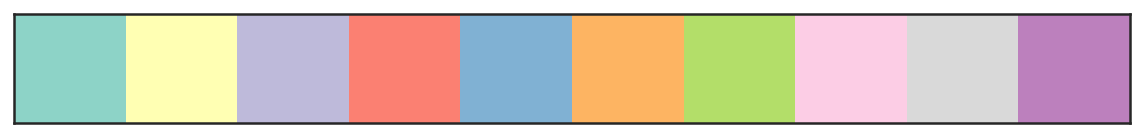

In [98]:
qualitative_colors = sns.color_palette("Set3", 10)
sns.palplot(qualitative_colors)

##### plots https://towardsdatascience.com/make-your-data-talk-13072f84eeac

coolors https://coolors.co/d3582c-e86130-ff6b35-fb986a-d6d0e4-bdb0f7-3c6be3-173ea1

vivid https://coolors.co/d3582c-e86130-ff6b35-fd8250-7d8eed-5d7de8-3c6be3-2a55c2-173ea1-152651  
pastel https://coolors.co/eb7347-fb986a-eca983-efc1a7-f4dacc-e1dae3-cdd9f9-9ab2f3-3c6be3-173ea1

# Gender distribution

In [537]:
gen_dist = df['sex'].value_counts(normalize=True) * 100
print(gen_dist)

female    72.063612
male      27.936388
Name: sex, dtype: float64


# Countries ans cities distribution

In [225]:
df.country.dropna()

0          Россия
1          Россия
2             США
3          Россия
4          Россия
            ...  
2507432    Россия
2507433    Россия
2507436    Россия
2507441    Россия
2507443    Россия
Name: country, Length: 2158610, dtype: object

In [73]:
#remove NA-values in columns 'country'&'city'
##save three variables: 'country', 'city', 'age'
cities = df[(df.country.notna()) & (df.city.notna())][['country', 'city', 'age']]

In [189]:
df.shape

(2507443, 7)

In [79]:
#from 2.5kk table has redused to 1.9kk
cities

,country,city,age
0,Россия,Москва,33
1,Россия,Санкт-Петербург,34
2,США,Boston,34
3,Россия,Санкт-Петербург,35
4,Россия,Санкт-Петербург,36
...,...,...,...
2507432,Россия,Москва,29
2507433,Россия,Волгоград,32
2507436,Россия,Краснодар,29
2507441,Россия,Нижний Новгород,23


In [132]:
#groupby table by 'country'&'city' and apply aggregation
cities_grouped = cities.groupby(['country','city']).agg({'age':'median','city':'count'})

In [135]:
#rename columns
cities_grouped.columns = ['median_age', 'city_count']

In [138]:
#reset index and sort by 'city_count'
cities_grouped = cities_grouped.reset_index().sort_values(by='city_count', ascending=False)

In [142]:
#drop duplicates in the city variable!
cities_grouped = cities_grouped.drop_duplicates(subset=['city'])

In [190]:
#we've got more than 200 countries (of 197 official)
##because there're unofficial states and other territories
print('Кол-во государств и прочих гос. образований:',len(set(cities_grouped.country)))

Кол-во государств и прочих гос. образований: 231


In [143]:
#grouped table after droping duplicates
cities_grouped

,country,city,median_age,city_count
9686,Россия,Москва,28.0,256574
11755,Россия,Санкт-Петербург,29.0,161151
692,Беларусь,Минск,27.0,41169
6902,Россия,Екатеринбург,28.0,35367
7607,Россия,Казань,28.0,33068
...,...,...,...,...
8330,Россия,Косяково,24.0,1
8331,Россия,Котегурт,24.0,1
8335,Россия,Котельный Мыс,42.0,1
8343,Россия,Коточиги,17.0,1


In [144]:
def region(f):
    '''takes in the variable COUNTRY, returns a new categorical variable 
    in a new column depending on the condition of the country belonging to group of countries'''
    
    if f['country']=='Россия': 
        return 'Россия'
    elif f['country'] in ['Украина','Узбекистан','Туркменистан','Таджикистан','Молдова',
                          'Кыргызстан','Казахстан','Беларусь','Армения','Азербайджан']:
        return 'СНГ'
    else: 
        return 'Другие страны'

In [145]:
#apply function
cities_grouped['regions'] = cities_grouped.apply(region, axis=1)

<ipython-input-145-3f77fc6fe424>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_grouped['regions'] = cities_grouped.apply(region, axis=1)


In [146]:
#we've got the column 'regions'
cities_grouped

,country,city,median_age,city_count,regions
9686,Россия,Москва,28.0,256574,Россия
11755,Россия,Санкт-Петербург,29.0,161151,Россия
692,Беларусь,Минск,27.0,41169,СНГ
6902,Россия,Екатеринбург,28.0,35367,Россия
7607,Россия,Казань,28.0,33068,Россия
...,...,...,...,...,...
8330,Россия,Косяково,24.0,1,Россия
8331,Россия,Котегурт,24.0,1,Россия
8335,Россия,Котельный Мыс,42.0,1,Россия
8343,Россия,Коточиги,17.0,1,Россия


In [163]:
#make a pivot table for REGIONS
cities_grouped.groupby('regions').agg({'country':lambda x: x.nunique(),
                                       'city':lambda x: x.nunique(),
                                       'city_count':'sum',
                                       'median_age':'mean'})

,country,city,city_count,median_age
regions,,,,
Другие страны,220,4900,70766,31.404291
Россия,1,9769,1496268,31.001436
СНГ,10,3519,309081,28.770737


In [ ]:
##we can clean coutries manually, to remove exra countries that are not official
# fnames = {'Американское Самоа':'США','Ангилья':'Великобритания',
#          'Аруба':'Нидерланды','Багамы':'Великобритания','Бермуды':'Великобритания',
#          'Виргинские острова, Великобритания':'Великобритания',
#          'Виргинские острова, США':'США','Гваделупа':'Франция',
#          'Гибралтар':'Великобритания','Гонконг':'Китай','Гренландия':'Дания',
#          'Гуам':'США','Конго, демократическая республика':'Конго',
#          'Кюрасао':'Нидерланды','Макао':'Китай','Мартиника':'Франция',
#          'Монтсеррат':'Великобритания'}

In [181]:
##countries from this set
# all_countries_clean = set(cities_grouped.country)
# all_countries_clean

{'Австралия',
 'Австрия',
 'Азербайджан',
 'Албания',
 'Алжир',
 'Американское Самоа',
 'Ангилья',
 'Ангола',
 'Андорра',
 'Антигуа и Барбуда',
 'Аргентина',
 'Армения',
 'Аруба',
 'Афганистан',
 'Багамы',
 'Бангладеш',
 'Барбадос',
 'Бахрейн',
 'Беларусь',
 'Белиз',
 'Бельгия',
 'Бенин',
 'Бермуды',
 'Болгария',
 'Боливия',
 'Босния и Герцеговина',
 'Ботсвана',
 'Бразилия',
 'Бруней',
 'Буркина-Фасо',
 'Бурунди',
 'Бутан',
 'Вануату',
 'Ватикан',
 'Великобритания',
 'Венгрия',
 'Венесуэла',
 'Виргинские острова, Великобритания',
 'Виргинские острова, США',
 'Восточный Тимор',
 'Вьетнам',
 'Габон',
 'Гаити',
 'Гайана',
 'Гамбия',
 'Гана',
 'Гваделупа',
 'Гватемала',
 'Гвинея',
 'Гвинея-Бисау',
 'Германия',
 'Гибралтар',
 'Гондурас',
 'Гонконг',
 'Гренада',
 'Гренландия',
 'Греция',
 'Грузия',
 'Гуам',
 'Дания',
 'Джибути',
 'Доминика',
 'Доминиканская Республика',
 'Египет',
 'Замбия',
 'Западная Сахара',
 'Зимбабве',
 'Израиль',
 'Индия',
 'Индонезия',
 'Иордания',
 'Ирак',
 'Иран',
 

### Russian statistics

In [152]:
cities_grouped_rus = cities_grouped[cities_grouped['regions']=='Россия']
cities_grouped_rus['norm'] = (round(cities_grouped_rus['city_count']
                                    /sum(cities_grouped_rus['city_count']) * 100, 4))

<ipython-input-152-068077b08ade>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_grouped_rus['norm'] = (round(cities_grouped_rus['city_count']


In [156]:
cities_grouped_rus.head(7)

,country,city,median_age,city_count,regions,norm
9686,Россия,Москва,28.0,256574,Россия,17.1476
11755,Россия,Санкт-Петербург,29.0,161151,Россия,10.7702
6902,Россия,Екатеринбург,28.0,35367,Россия,2.3637
7607,Россия,Казань,28.0,33068,Россия,2.2100
10331,Россия,Новосибирск,28.0,32296,Россия,2.1584
8429,Россия,Краснодар,27.0,27239,Россия,1.8205
10011,Россия,Нижний Новгород,28.0,26942,Россия,1.8006


## Russian cities statistics by age

In [318]:
#some age variables may by false because of users can choose any date from 1902
##we manually choose the most reasonable age interval
#sorted(Counter(df.age.dropna()).items())  ##chosen 66 y.o.

In [319]:
cities_grouped_rus_ = cities_grouped_rus[cities_grouped_rus['median_age']<=66]

In [324]:
print('Минимальный возраст в таблице:',cities_grouped_rus_.median_age.min())
print('Максимальный возраст в таблице:',cities_grouped_rus_.median_age.max())

Минимальный возраст в таблице: 14.0
Максимальный возраст в таблице: 66.0


In [328]:
def age_groups(f):
    '''takes in the variable median_age, returns a new categorical variable 
    in a new column depending on the condition of the median_age belonging 
    to one of the age intervals'''
    
    if f['median_age'] <= 20: 
        return '14-20 лет', 1
    elif 20 < f['median_age'] <= 25:
        return '20-25 лет', 2
    elif 25 < f['median_age'] <= 30:
        return '25-30 лет', 3    
    elif 30 < f['median_age'] <= 35:
        return '30-35 лет', 4
    elif 35 < f['median_age'] <= 40:
        return '35-40 лет', 5
    elif 40 < f['median_age'] <= 45:
        return '40-45 лет', 6    
    elif 45 < f['median_age'] <= 50:
        return '45-50 лет', 7 
    elif 50 < f['median_age'] <= 55:
        return '50-55 лет', 8
    elif 55 < f['median_age'] <= 60:
        return '55-60 лет', 9     
    else: 
        return '60-66 лет', 10

In [344]:
#apply function
cities_grouped_rus_['age_interval'] = cities_grouped_rus_.apply(age_groups, axis=1)

<ipython-input-344-cb83bdc1b80b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_grouped_rus_['age_interval'] = cities_grouped_rus_.apply(age_groups, axis=1)


In [346]:
cities_grouped_rus_['age_interval'], cities_grouped_rus_['age_interval_cat'] = cities_grouped_rus_['age_interval'].str

<ipython-input-346-38053c035d97>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  cities_grouped_rus_['age_interval'], cities_grouped_rus_['age_interval_cat'] = cities_grouped_rus_['age_interval'].str
<ipython-input-346-38053c035d97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_grouped_rus_['age_interval'], cities_grouped_rus_['age_interval_cat'] = cities_grouped_rus_['age_interval'].str


In [350]:
sum(cities_grouped_rus_.city_count)

1494535

In [349]:
cities_grouped_rus_

,country,city,median_age,city_count,regions,norm,age_interval,age_interval_cat
9686,Россия,Москва,28.0,256574,Россия,17.1476,25-30 лет,3
11755,Россия,Санкт-Петербург,29.0,161151,Россия,10.7702,25-30 лет,3
6902,Россия,Екатеринбург,28.0,35367,Россия,2.3637,25-30 лет,3
7607,Россия,Казань,28.0,33068,Россия,2.2100,25-30 лет,3
10331,Россия,Новосибирск,28.0,32296,Россия,2.1584,25-30 лет,3
...,...,...,...,...,...,...,...,...
8321,Россия,Костово,23.0,1,Россия,0.0001,20-25 лет,2
8330,Россия,Косяково,24.0,1,Россия,0.0001,20-25 лет,2
8331,Россия,Котегурт,24.0,1,Россия,0.0001,20-25 лет,2
8335,Россия,Котельный Мыс,42.0,1,Россия,0.0001,40-45 лет,6


In [348]:
cities_grouped_rus_.to_csv('data/RUS_CITIES_WITH_AGE.csv')

In [ ]:
#E1DAE3 

In [286]:
#groupby to see age distribution across russian cities
rus_cities_by_age = (cities_grouped_rus.groupby('median_age')
                     .agg({'city':lambda x: list(x)[:3],
                     'city_count':'sum'})
                     #'city_count':'sum'})
                     .reset_index()
                     .sort_values('city_count', ascending=False))

In [287]:
rus_cities_by_age

,median_age,city,city_count
27,28.0,"[Москва, Екатеринбург, Казань]",875506
29,29.0,"[Санкт-Петербург, Тольятти, Набережные Челны]",312769
25,27.0,"[Краснодар, Воронеж, Волгоград]",211879
31,30.0,"[Рыбинск, Нефтекамск, Элиста]",37577
33,31.0,"[Мелеуз, Сатка, Вельск]",11509
...,...,...,...
120,95.0,[Приморка],1
128,110.0,[Петушки (деревня)],1
127,108.0,[Могильник],1
126,106.0,[Новый Ислам],1


In [296]:
(rus_cities_by_age[(rus_cities_by_age['city_count']>2)
                   &(rus_cities_by_age['median_age']<90)]
                   .sort_values('median_age'))

,median_age,city,city_count
0,14.0,"[Бергин, Приупский, Большие Кибячи]",11
1,15.0,"[Подболотье, Арда, Добровольск]",41
2,15.5,[Верх-Чита],4
3,16.0,"[Аксеново-Зиловское, Дядьковская, Шемышейка]",76
4,16.5,[Кундравы],8
...,...,...,...
113,79.0,[Зуткулей],4
114,80.0,"[Семисотка, Могильный Мыс]",3
115,81.0,"[Межегей, Якут]",6
116,82.0,"[Шабельское, Шатмантамак, Клушино]",3


In [270]:
rus_cities_by_age.to_csv('data/RUS_CITIES_BY_AGE.cs')

### CIS statistics

In [154]:
cities_grouped_sng = cities_grouped[cities_grouped['regions']=='СНГ']
cities_grouped_sng['norm'] = (round(cities_grouped_sng['city_count']
                                    /sum(cities_grouped_sng['city_count']) * 100, 4))

<ipython-input-154-8a73cd1ac44d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_grouped_sng['norm'] = (round(cities_grouped_sng['city_count']


In [157]:
cities_grouped_sng.head(7)

,country,city,median_age,city_count,regions,norm
692,Беларусь,Минск,27.0,41169,СНГ,13.3198
16702,Украина,Киев,27.0,32834,СНГ,10.6231
18053,Украина,Харьков,27.0,16993,СНГ,5.4979
17322,Украина,Одесса,28.0,13787,СНГ,4.4606
3009,Казахстан,Алматы,28.0,13767,СНГ,4.4542
16410,Украина,Днепропетровск (Днепр),28.0,9087,СНГ,2.9400
16440,Украина,Донецк,28.0,7838,СНГ,2.5359


### Other countries statistics

In [158]:
cities_grouped_other = cities_grouped[cities_grouped['regions']=='Другие страны']
cities_grouped_other['norm'] = (round(cities_grouped_other['city_count']
                                    /sum(cities_grouped_other['city_count']) * 100, 4))

<ipython-input-158-b63c0574bd26>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_grouped_other['norm'] = (round(cities_grouped_other['city_count']


In [159]:
cities_grouped_other.head(7)

,country,city,median_age,city_count,regions,norm
15134,США,New York City,27.0,3380,Другие страны,4.7763
15010,США,Los Angeles,27.0,2940,Другие страны,4.1545
18618,Чехия,Praha,27.0,1942,Другие страны,2.7443
18820,Эстония,Tallinn (Таллин),27.0,1861,Другие страны,2.6298
1348,Великобритания,London,28.0,1651,Другие страны,2.3330
1581,Германия,Berlin,28.0,1545,Другие страны,2.1833
3685,Латвия,Rīga,27.0,1545,Другие страны,2.1833


## Append tables

In [193]:
all_cities = cities_grouped_rus.append([cities_grouped_sng, cities_grouped_other], ignore_index=True)

In [194]:
all_cities

,country,city,median_age,city_count,regions,norm
0,Россия,Москва,28.0,256574,Россия,17.1476
1,Россия,Санкт-Петербург,29.0,161151,Россия,10.7702
2,Россия,Екатеринбург,28.0,35367,Россия,2.3637
3,Россия,Казань,28.0,33068,Россия,2.2100
4,Россия,Новосибирск,28.0,32296,Россия,2.1584
...,...,...,...,...,...,...
18183,Германия,Nordhorn,26.0,1,Другие страны,0.0014
18184,Германия,Nordwalde,27.0,1,Другие страны,0.0014
18185,Германия,Norwegen,NaN,1,Другие страны,0.0014
18186,Германия,Nürnberger Hof,23.0,1,Другие страны,0.0014


In [164]:
all_cities.to_csv('data/CITIES.csv')

## All countries istribution

In [219]:
country_dist = all_cities.groupby(['country','regions']).agg({'city_count':'sum'}).reset_index()

In [220]:
country_dist['norm_all_countries'] = (round(country_dist['city_count']
                                    /sum(country_dist['city_count']) * 100, 4))

In [221]:
country_dist = country_dist.sort_values('norm_all_countries', ascending = False).reset_index().drop('index',1)

In [222]:
country_dist

,country,regions,city_count,norm_all_countries
0,Россия,Россия,1496268,79.7535
1,Украина,СНГ,161720,8.6199
2,Беларусь,СНГ,92052,4.9065
3,Казахстан,СНГ,41972,2.2372
4,США,Другие страны,14419,0.7686
...,...,...,...,...
226,Малави,Другие страны,4,0.0002
227,Коморы,Другие страны,4,0.0002
228,Монтсеррат,Другие страны,1,0.0001
229,Лесото,Другие страны,1,0.0001


In [223]:
country_dist.to_csv('data/COUNTRIES_DISTRIBUTION.csv')

## Age distribution

In [715]:
print('Sample with age data:', len(df.age.dropna()))

Sample with age data: 1641092


In [719]:
print('MEN')
df_age_men = df[(df.age < df.age.quantile(.95)) & (df.sex == 'male')]['age']
co_men = Counter(df_age_men)
df_co_men = pd.DataFrame.from_dict(co_men, orient='index').reset_index().sort_values(by='index')

df_co_men['norm'] = round(df_co_men[0] / sum(df_co_men[0]) * 100, 2)
print('Median:',df_co_men.median()['index'])
print('Max:', df_co_men.max()['index'])
print('Min:', df_co_men.min()['index'])
print('Largest age groups:\n', df_co_men.nlargest(5, columns = 0))

MEN
Median: 31.0
Max: 48.0
Min: 14.0
Largest age groups:
     index      0  norm
19     27  30296  7.09
4      26  29859  6.99
9      28  28779  6.73
11     29  28609  6.69
10     25  27988  6.55


In [720]:
print('WOMEN')
df_age_women = df[(df.age < df.age.quantile(.95)) & (df.sex == 'female')]['age']
co_women = Counter(df_age_women)
df_co_women = pd.DataFrame.from_dict(co_women, orient='index').reset_index().sort_values(by='index')

df_co_women['norm'] = round(df_co_women[0] / sum(df_co_women[0]) * 100, 2)
print('Median:', df_co_women.median()['index'])
print('Max:', df_co_women.max()['index'])
print('Min:', df_co_women.min()['index'])
print('Largest age groups:\n', df_co_women.nlargest(5, columns = 0))

WOMEN
Median: 31.0
Max: 48.0
Min: 14.0
Largest age groups:
     index      0  norm
15     27  90783  8.03
27     26  90031  7.96
18     25  84451  7.47
8      28  83467  7.38
17     29  78716  6.96


In [639]:
df_co_women['sex'] = 'female'
df_co_men['sex'] = 'male'

result = pd.concat([df_co_women, df_co_men])
result = result.rename(columns={'index':'age', 0:'count', 'norm':'%'})

In [703]:
result.head(2)

,age,count,%,sex
19,14,1408,0.12,female
13,15,8239,0.73,female


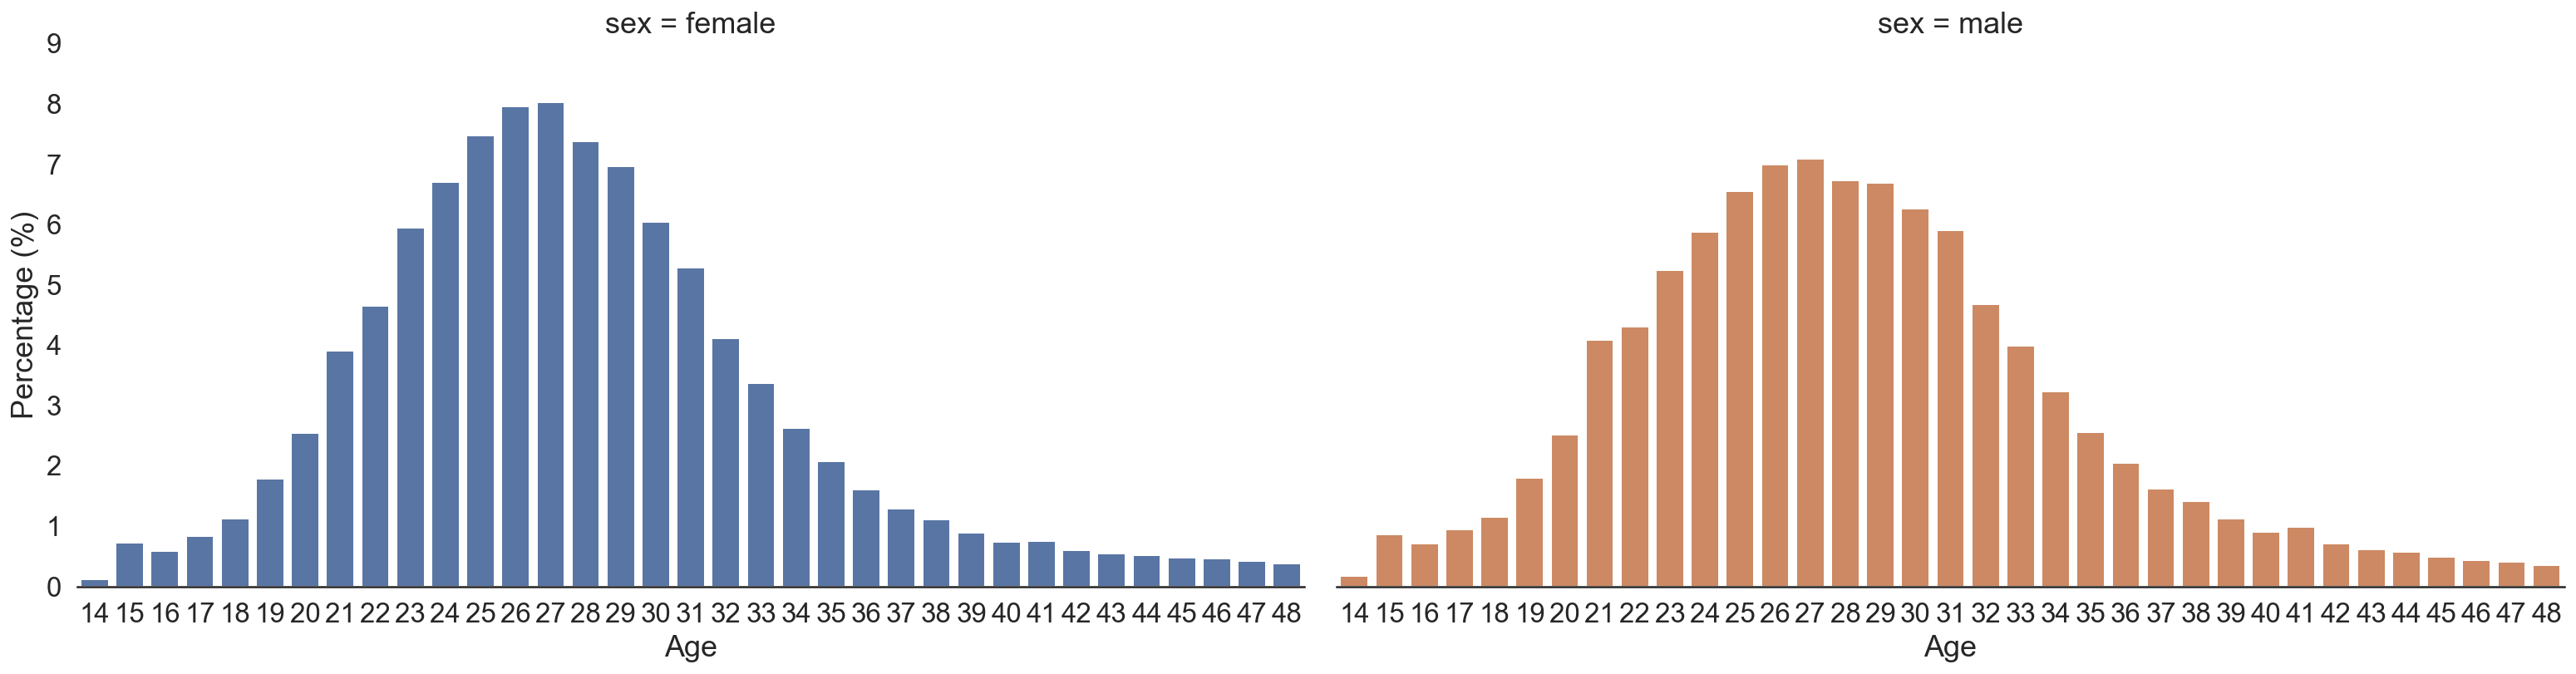

In [702]:
g = sns.catplot(ax=ax, x='age', y='%',
                hue='sex', col='sex',
                data=result, kind='bar',
                height=6, aspect=31/17,
                dodge=False);

(g.set_axis_labels('Age', 'Percentage (%)')
 .set(ylim=(0, 9))
 .despine(left=True));

In [704]:
g.savefig('pics/age_dist_catplot.svg')